In [1]:
import json
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from tqdm import tqdm

from src.files_io import download_and_extract_raw_datasets, load_raw_population_datasets
from src.preprocessing import preprocess_data

# Load & Preprocess Data
We start by loading the datasets with the demographic data and preprocess them with the developed processing rules from the data exploration notebook.

In [2]:
download_and_extract_raw_datasets()

Raw Datasets already exists.


In [3]:
population_raw, customer_raw = load_raw_population_datasets()

Population datasets loaded.


In [4]:
population, customer = preprocess_data(population_raw, customer_raw, names=("population", "customer"))

Metadata loaded.
Metadata rectified.
Feature config loaded.

Start cleaning population dataset...
Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 8 invalid values to null in the dataset.
Removed 105801 records with over 33.0% missing feature values.
Removed 16 features with over 20.0% missing values:
alter_hh, alter_kind3, alter_kind4, alterskategorie_fein, d19_banken_online_quote_12, d19_gesamt_online_quote_12, d19_konsumtyp, d19_lotto, d19_soziales, d19_telko_online_quote_12, d19_versand_online_quote_12, d19_versi_online_quote_12, extsel992, geburtsjahr, kba05_baumax, kk_kundentyp
Replaced missing values in 129 features.
Extracted decade and cultural orientation as separate features.
Extracted wealth and life phase as separate features.
Removed 51 redundant features.
Removed 24 uncertain features.

Start cleaning customer dataset...
Removed 6 irrelevant features.
Converted 324 unknown values from the meta informa

For the upcoming PCA and K-Means clustering we need to combine both preprocessed datasets.

To be able to distinguish between customers and general population, we add a column `is_customer`.

In [5]:
population["is_customer"] = False
customer["is_customer"] = True

In [6]:
preprocessed_df = pd.concat([population, customer], ignore_index=True)

The first clustering approach with the envisaged processing rules has shown, that there is too much noise in the data, so the clustering results were unreliable. Better results were achieved by removing the `kba` and `d19` features, which heavily decreases the dimensionality. More details are below in the silhouette score section.

In [7]:
preprocessed_df = preprocessed_df.drop(columns=[col for col in preprocessed_df.columns if col.startswith("kba") or col.startswith("d19")])

# Principal Component Analysis
Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional form while preserving as much variance as possible.

PCA is essential for K-Means clustering, because it helps eliminate noise and irrelevant features that can mislead the clustering process. This is why PCA can improve the accuracy and stability of K-Means clustering results.

The explained variance in PCA refers to the amount of the total variance in the data that is captured by each principal component. It indicates how much information from the original data is preserved by that component.

I initially used 90% explained variance, but this resulted in poor cluster quality, as indicated by a low silhouette score. For our customer segmentation it is essential to have a reliable cluster quality, so I prioritized well-separated, interpretable clusters over preserving variance. Therefore, I gradually reduced the explained variance until the silhouette score improved sufficiently. An explained variance of 50% yielded 7 principal components, which proved effective for the customer segmentation.

In [8]:
explained_variance = 0.5
pca = PCA(n_components=explained_variance, random_state=42)

pca_data = pca.fit_transform(preprocessed_df.drop(columns=["is_customer"]))
print(f"Number of PCA components retained: {pca.n_components_}")

pca_df = pd.DataFrame(
    data=pca_data,
    columns=[f"principal_component_{i+1}" for i in range(pca.n_components_)]
)

pca_df = pd.concat([pca_df, preprocessed_df["is_customer"]], axis=1)

Number of PCA components retained: 7


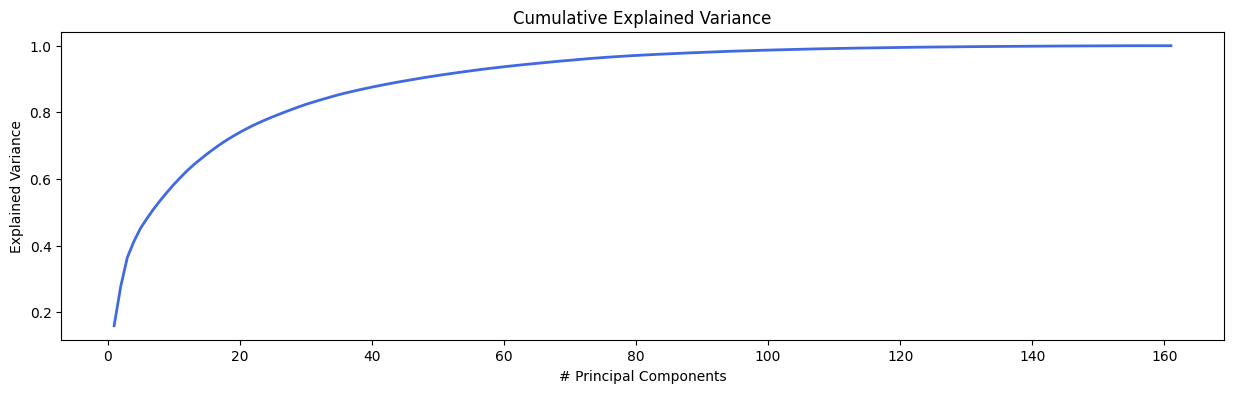

In [9]:
def plot_principal_components_by_explained_variance(df: pd.DataFrame) -> None:
    """
    Plots principal components by explained variance

    :param df: Preprocessed dataset before applying PCA
    """
    pca_plot = PCA(random_state=42)
    pca_plot.fit(df.drop(columns=["is_customer"]))

    fig_df = pd.DataFrame({
        "Principal Component": range(1, len(pca_plot.explained_variance_ratio_) + 1),
        "Cumulative Variance": np.cumsum(pca_plot.explained_variance_ratio_)
    })

    plt.figure(figsize=(15, 4))
    plt.plot(fig_df["Principal Component"], fig_df["Cumulative Variance"], color="royalblue", linewidth=2)

    plt.title("Cumulative Explained Variance")
    plt.xlabel("# Principal Components")
    plt.ylabel("Explained Variance")

    plt.show()


plot_principal_components_by_explained_variance(preprocessed_df)

# K-Means Clustering
For the clustering we will use K-Means, which partitions data into a predefined number of clusters by minimizing the distance between data points and their respective cluster centroids. It iteratively updates the centroids and reassigns points until the clusters stabilize. K-Means is a good choice for our customer segmentation because it is simple, efficient on large datasets, and often produces well-separated, interpretable clusters.

## Find Optimal K
Since K-Means requires a predefined number of clusters, it is important to determine the optimal number for our dataset.

Common techniques for this are the elbow method and the silhouette score. To apply these techniques, we first have to test different numbers of clusters and collect the corresponding results.

The computation of the silhouette score is computationally expensive, so we have to take a sample of 5000 individuals.

In [10]:
pca_features = pca_df.drop(columns=["is_customer"])

In [11]:
inertia = []
silhouette_scores = []
n_clusters_range = range(2, 16, 2)

for n_clusters in tqdm(n_clusters_range):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    cluster_labels = kmeans.fit_predict(pca_features)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(pca_features, cluster_labels, sample_size=5000)
    silhouette_scores.append(silhouette_avg)

100%|██████████| 7/7 [00:22<00:00,  3.16s/it]


### Elbow Method
For the elbow method we have to plot the within-cluster sum of squares (WCSS or Inertia) against the number of clusters and identifying the "elbow point".

In our case the "elbow point" was hardly distinguishable.

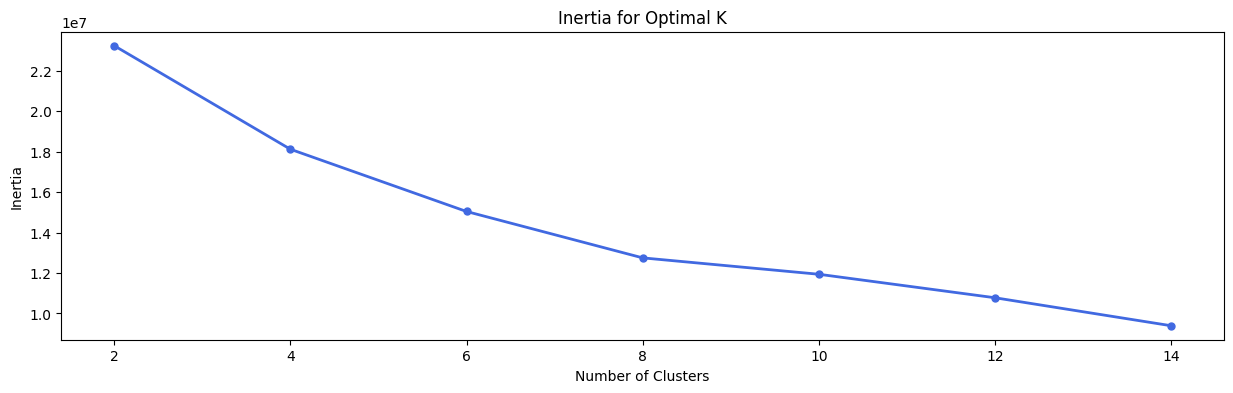

In [12]:
def plot_n_clusters_curve(n_clusters_range: range, measure_data: List[float], measure_name: str) -> None:
    """
    Plots specified measure for each computed number of clusters

    :param n_clusters_range: Range of computed number of clusters
    :param measure_data: Data of the measure
    :param measure_name: Name of the measure
    """
    data = pd.DataFrame({
        "Number of Clusters": n_clusters_range,
        measure_name: measure_data
    })

    plt.figure(figsize=(15, 4))
    plt.plot(data["Number of Clusters"], data[measure_name], color="royalblue", linewidth=2, marker="o", markersize=5)

    plt.title(f"{measure_name} for Optimal K")
    plt.xlabel("Number of Clusters")
    plt.ylabel(measure_name)

    plt.show()

plot_n_clusters_curve(n_clusters_range, inertia, "Inertia")

### Silhouette Score
The silhouette score measures how similar a data point is to its own cluster compared to other clusters. Higher scores indicating better-defined and more separated clusters.

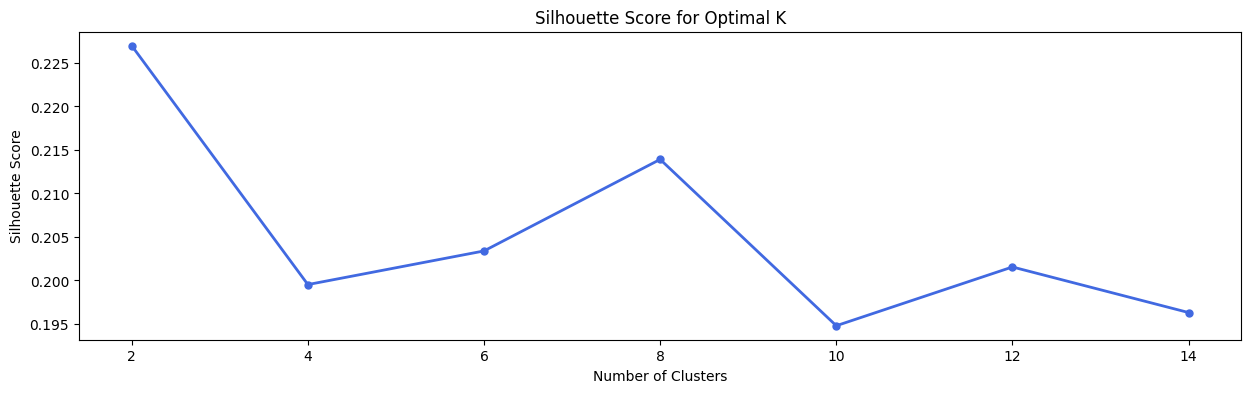

In [13]:
plot_n_clusters_curve(n_clusters_range, silhouette_scores, "Silhouette Score")

We reached the highest scores for 2 and 8 clusters. For our customer segmentation we take the more granular clusters.

After finally training the K-Means model with 8 clusters, we assign the labels to our combined dataset.



In [14]:
optimal_k = 8

In [15]:
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", random_state=42)
cluster_labels = kmeans.fit_predict(pca_features)

pca_df["cluster"] = cluster_labels

# Cluster Analysis
## Customer Proportions
We have to identify which clusters have a high proportion of customers to gain insights about the customer characteristics based on these customer-heavy clusters.

If we look at the distribution of our clusters, we notice that the cluster number 4 stands out with a proportion of 37%.

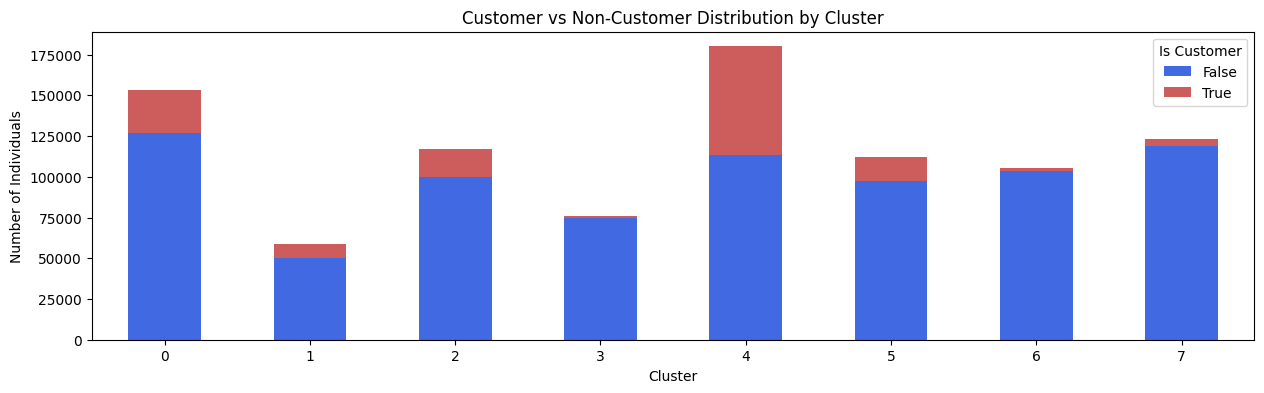

In [16]:
def plot_customer_distribution_by_cluster(pca_df: pd.DataFrame) -> None:
    """
    Plots the customer distribution by each cluster

    :param pca_df: Dataset after PCA applied
    """
    cluster_counts = pca_df.groupby(["cluster", "is_customer"]).size().reset_index(name="count")

    cluster_counts = cluster_counts.pivot(index="cluster", columns="is_customer", values="count").fillna(0)

    ax = cluster_counts.plot(kind="bar", stacked=True, figsize=(15, 4), color=["royalblue", "indianred"])

    plt.title("Customer vs Non-Customer Distribution by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("Number of Individuals")
    plt.xticks(rotation=0)

    plt.legend(title="Is Customer", labels=cluster_counts.columns)

    plt.show()


plot_customer_distribution_by_cluster(pca_df)

In [17]:
customer_cluster_ratios = pca_df.groupby("cluster", as_index=False)["is_customer"].agg(["count", "sum"])
customer_cluster_ratios["customer_ratio"] = round(customer_cluster_ratios["sum"] / customer_cluster_ratios["count"], 2)
customer_cluster_ratios.sort_values("customer_ratio", ascending=False).head()

,cluster,count,sum,customer_ratio
4,4,180039,66722,0.37
0,0,153387,26444,0.17
2,2,117098,16987,0.15
1,1,58758,8649,0.15
5,5,111920,14245,0.13


## Principal Components
First, we examine the customer-heavy cluster by its principal components to get an idea of how the cluster is positioned along each principal component.

Component #1 is clearly above the average, while component #3 is noticeably below. We will focus on these two components.

In [18]:
cluster_id = 4
cluster_df = pca_df[pca_df["cluster"] == cluster_id]

pc_means = cluster_df[[col for col in cluster_df.columns if col.startswith("principal_component")]].mean()
pc_means.sort_values(ascending=False)

principal_component_1    3.292379
principal_component_7    0.126126
principal_component_4   -0.013939
principal_component_6   -0.162057
principal_component_5   -0.257828
principal_component_2   -0.297350
principal_component_3   -1.991794
dtype: float64

Each principal component is a linear combination of the original variables. The loadings indicate how much each original variable contributes to each principal component. The sign of the loading (positive or negative) indicates the direction of the relationship.

The loadings of component #1 indicates relationships to these features:
- `lp_status_fein` - higher social status
- `finanz_minimalist` - higher financial interest
- `mobi_regio` - lower mobility
- `plz8_antg1` - higher share of 1-2 family houses
- `plz8_antg2` - less share of 3-5 family houses
- `konsumnaehe` - higher distance from building to Point of Sale
- `innenstadt` - higher distance to city center
- `zabeotyp` - consume more smart and green energy

This cluster of individuals could possibly be described as affluent, stable homeowners who live in rural or suburban areas. They exhibit higher social status through homeownership and top earnings, demonstrate a strong financial awareness, and prefer single-family homes. With lower mobility and greater distances from urban centers and points of sale, they value a quieter lifestyle. Additionally, they show a commitment to sustainability by consuming more smart and green energy, reflecting their environmentally conscious mindset.

In [19]:
original_feature_names = preprocessed_df.drop(columns="is_customer").columns

loadings_pc_1 = pd.Series(pca.components_[0], index=original_feature_names)
loadings_pc_1[abs(loadings_pc_1) > 0.15].sort_values(ascending=False)

lp_status_fein        0.244576
finanz_minimalist     0.242410
mobi_regio            0.240086
plz8_antg1            0.232154
konsumnaehe           0.178109
plz8_gbz              0.165440
innenstadt            0.161343
firmendichte          0.161011
plz8_antg2           -0.159213
zabeotyp             -0.164315
finanz_hausbauer     -0.172783
ortsgr_kls9          -0.191947
cameo_deug_2015      -0.217746
plz8_baumax          -0.219953
plz8_antg4           -0.221000
hh_einkommen_score   -0.223824
plz8_antg3           -0.228013
dtype: float64

The `semio` features dominate component #3, which describes different personal affinities:
- `semio_kaem` - less fightful attitude
- `semio_dom` - less dominant minded
- `semio_krit` - less critical minded
- `semio_erl` - less eventful orientated
- `semio_rat` - less rational minded
- `semio_kult` - more cultural minded
- `semio_soz` - more social minded
- `semio_fam` - more familiar minded
- `semio_vert` - more dreamily

This cluster of individuals could possibly be characterized as more gentle and community-oriented, exhibiting a softer approach to life. They tend to have a less confrontational and dominant attitude, preferring harmony over conflict. With a lower emphasis on critical thinking and rationality, they are more inclined towards cultural appreciation and social connections. Their focus on family and relationships suggests a strong sense of familiarity and belonging.

In [20]:
loadings_pc_3 = pd.Series(pca.components_[2], index=original_feature_names)
loadings_pc_3[abs(loadings_pc_3) > 0.15].sort_values(ascending=False)

semio_kaem        0.351897
semio_dom         0.315852
semio_krit        0.304208
semio_erl         0.220262
anrede_kz         0.187897
semio_rat         0.185826
finanz_anleger    0.181347
semio_kult       -0.265564
semio_soz        -0.272971
semio_fam        -0.275055
semio_vert       -0.350240
dtype: float64

## Original Data
Another possibility to gain insights is to analyze the original data values. We can compare the values of the customer-heavy cluster with the total data to discover specific traits of that cluster.

To interpret the values correctly, we need the cleaned original data, but not scaled or encoded.

In [21]:
population_cleaned, customer_cleaned = preprocess_data(population_raw, customer_raw, names=("population", "customer"), clean_only=True)

Metadata loaded.
Metadata rectified.
Feature config loaded.

Start cleaning population dataset...
Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 8 invalid values to null in the dataset.
Removed 105801 records with over 33.0% missing feature values.
Removed 16 features with over 20.0% missing values:
alter_hh, alter_kind3, alter_kind4, alterskategorie_fein, d19_banken_online_quote_12, d19_gesamt_online_quote_12, d19_konsumtyp, d19_lotto, d19_soziales, d19_telko_online_quote_12, d19_versand_online_quote_12, d19_versi_online_quote_12, extsel992, geburtsjahr, kba05_baumax, kk_kundentyp
Replaced missing values in 129 features.
Extracted decade and cultural orientation as separate features.
Extracted wealth and life phase as separate features.
Removed 51 redundant features.
Removed 24 uncertain features.

Start cleaning customer dataset...
Removed 6 irrelevant features.
Converted 324 unknown values from the meta informa

We also have to add the `cluster` labels to the original data and remove `kba` and `d19` features, that were not used for clustering.

With the added `cluster` label we can select the individuals from the customer-heavy cluster.

In [22]:
original_df = pd.concat([population_cleaned, customer_cleaned], ignore_index=True)
original_df = original_df.drop(columns=[col for col in original_df.columns if col.startswith("kba")])
original_df = original_df.drop(columns=[col for col in original_df.columns if col.startswith("d19")])

original_df["cluster"] = pca_df["cluster"]

cluster_df = original_df[original_df["cluster"] == 4].copy()

### Numerical Values

To evaluate the numeric features, we can calculate and compare the means for the customer-heavy cluster and total dataset.

Some of the largest differences (relative deviation >30%) we can observe fits well to the findings of the analyzed principal components, but there are also some additional characteristics revealed:

| Feature             | Compared to Average Population              | Cluster Average Value       |
|---------------------|---------------------------------------------|-----------------------------|
| anz_haushalte_aktiv | less households per building                | 1-2 households per building |
| anz_kinder          | less children                               | 0.022                       |
| anz_titel           | more individuals with academic title        | no academic title           |
| cameo_deug_2015     | higher social status                        | established middleclass     |
| finanz_anleger      | more financial investors                    | high to very high           |
| finanz_minimalist   | higher financial interest                   | low interest = very low     |
| finanz_hausbauer    | higher financial main focus on an own house | high focus                  |
| hh_einkommen_score  | higher income                               | high income                 |
| lp_status_fein      | higher social status                        | (new) houseowners           |
| mobi_regio          | lower mobility                              | low mobility                |
| plz8_antg3          | less 6-10 family houses                     | low share                   |
| plz8_antg4          | less >10 family houses                      | none                        |
| plz8_baumax         | more 1-2 family houses                      | mainly 1-2 family homes     |
| semio_kaem          | less >10 family houses                      | none                        |
| semio_vert          | lower dreamily affinity                     | very low affinity           |
| zabeotyp            | smarter energy consumption                  | smart                       |

An interesting observation is, that we saw an inverse relationship between a dreamy affinity and the principal component #3 before, but the analysis of the original values cleary show that that assumption was misleading.

In [23]:
with open("./src/feature_config.json", "r") as f:
    feature_config = json.load(f)

non_numeric_features = feature_config["categorical"] + feature_config["binary"] + ["is_customer", "cluster"]
numeric_features = [col for col in original_df.columns if col not in non_numeric_features]

cluster_means = cluster_df[numeric_features].mean().T
total_means = original_df[numeric_features].mean().T

means = pd.concat([cluster_means, total_means], axis=1)
means.columns = ["cluster", "total"]

means["rel_diff"] = round((means["cluster"] / means["total"] - 1) * 100, 1)
means[(abs(means["rel_diff"]) > 30)].sort_values(["rel_diff"], ascending=False)

,cluster,total,rel_diff
anz_titel,0.013764,0.006578,109.2
lp_status_fein,8.424119,5.148061,63.6
finanz_minimalist,4.754342,3.240081,46.7
semio_vert,6.143691,4.412237,39.2
mobi_regio,4.117336,3.071584,34.0
finanz_hausbauer,2.131299,3.064491,-30.5
cameo_deug_2015,3.694238,5.356322,-31.0
hh_einkommen_score,2.907809,4.242474,-31.5
zabeotyp,2.132588,3.233908,-34.1
plz8_antg3,1.009903,1.568689,-35.6


### Categorical Values

To assess the categorical variables, we count each categorical value in the cluster as well as in the total data with all individuals.

We order that value counts by its relative share of the cluster count versus the corresponding value count in the total data.

In [32]:
cluster_df["type"] = "cluster"
original_df["type"] = "total"


def list_categorical_diffs(
    feature: str,
    cluster_df: pd.DataFrame = cluster_df,
    original_df: pd.DataFrame = original_df
) -> pd.DataFrame:
    df = pd.concat([cluster_df, original_df], ignore_index=True)

    ct = pd.crosstab(df[feature], df["type"], normalize="index")
    ct = ct.reset_index()
    ct.columns.name = None

    ct = ct.rename(columns={feature: "value"})
    ct["feature"] = feature

    ct = ct.sort_values("cluster", ascending=False)

    return ct

The Top20 values with the highest share compared to the average population reveals some interesting customer traits:
- `titel_kz` - higher share of academic titles
- `cameo_deu_2015` - most of the upper class and upper middle class typologies are represented in the Top20 values with the highest share
- `anrede_kz` - more male customers
- `ager_typ` - more best-ager customers
- `gebaeudetyp` - higher share of buildings without actually known households
- `gfk_urlaubertyp` - more hiker and golden ager regarding the vacation habits
- `finanztyp` - more money savers as well as investors
- `shopping_type` - more individuals who seek pleasure and enjoyment from their shopping experiences
- `alterskategorie_grob` - higher share of >60 years old

Some of them were already uncovered in the previous analyses (higher social class, investors), but emphasize these insights.

In [34]:
value_cluster_share = []
for categorical_feature in tqdm(feature_config["categorical"] + feature_config["binary"]):
    value_cluster_share.append(list_categorical_diffs(categorical_feature))

value_cluster_share = pd.concat(value_cluster_share, ignore_index=True)

value_cluster_share.sort_values("cluster", ascending=False).head(20)

100%|██████████| 21/21 [00:04<00:00,  5.13it/s]


,value,cluster,total,feature
120,1,0.325673,0.674327,titel_kz
10,1D,0.322861,0.677139,cameo_deu_2015
0,0.0,0.321949,0.678051,ager_typ
66,2.0,0.316928,0.683072,gebaeudetyp
11,1E,0.311389,0.688611,cameo_deu_2015
1,1.0,0.310066,0.689934,ager_typ
67,4.0,0.284704,0.715296,gebaeudetyp
12,2D,0.277291,0.722709,cameo_deu_2015
106,1,0.276806,0.723194,anrede_kz
13,2C,0.273515,0.726485,cameo_deu_2015


## Cluster Profile
- Demographic Characteristics:
  - Social Status: The cluster is predominantly composed of individuals with a higher social status, categorized as established middle class and upper class. A significant share of the population holds academic titles, indicating a well-educated demographic.
  - Age Distribution: There is a notable presence of "best-ager" customers, with a higher concentration of individuals aged 60 and above.
  - Gender Composition: The cluster has a higher proportion of male customers.

- Housing and Living Situation:
  - Residential Characteristics: The cluster is characterized by a preference for 1-2 family houses, with a low share of multi-family housing. Many residents live in areas with fewer households per building, indicating a more spacious living environment.
  - Mobility: Residents exhibit lower mobility, with a higher distance from Points of Sale and city centers, suggesting a more suburban lifestyle.

- Financial Behavior:
  - Financial Interests: The cluster shows a strong inclination towards financial investments, with many individuals categorized as financial investors and money savers. There is a significant focus on home ownership, reflecting a preference for investing in personal property.
  - Income Levels: The average income within this cluster is higher than the general population, indicating a financially stable group.

- Consumption Patterns:
  - Energy Consumption: Customers in this segment are inclined towards smart and green energy solutions, reflecting a commitment to sustainability.
  - Shopping Preferences: The cluster members derive pleasure and enjoyment from shopping experiences, indicating a preference for leisure-oriented purchasing behavior.

- Personal Affinities:
  - Mindset and Attitudes: The cluster is characterized by less dominant, critical and rational thinking. Instead, members display a more cultural, social and familial mindset with a tendency towards a less eventful orientation.